In [22]:
%matplotlib inline

Expressibility-trainability tradeoff {#barren_plateaus}
==========================================

*Author: Cichy Simon (simon.cichy\@vertrauen.pro).

Reproducing some of the results presented in Holmes et al. (2021)  
Based on the demo on Barren plateaus in quantum neural networks  
With further inspiration from the demo on the Variational classifier  

Exploring the barren plateau problem with PennyLane
---------------------------------------------------

First, we import PennyLane, NumPy, and Matplotlib


In [23]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import datetime

Setting some parameters of the simulations

In [24]:
# Set a seed for reproducibility
np.random.seed(42)
num_samples = 1000

qubits = [2, 3, 4, 5, 6]
layers = [1, 2, 5, 10, 20, 50]
colours = ['#6f45d8', '#4547d8', '#45ccd8', '#45d859', '#c2d845', '#d89d45', '#d85645']

Plotting function

In [25]:
def plot_gradients(layer_list, qubit_list, circuit):
    for nl, num_layers in enumerate(layer_list):
        variances = []
        print(num_layers, " layers")

        for num_qubits in qubit_list:
            grad_vals = []
            print(num_qubits, " qubits")

            for _ in range(num_samples):
                dev = qml.device("default.qubit", wires=range(num_qubits))
                qcircuit = qml.QNode(circuit, dev)

                params = np.random.uniform(0, np.pi, size=(num_layers, num_qubits))

                gradient = qml.grad(qcircuit)(params)
                grad_vals.append(gradient[0][0])
            variances.append(np.var(grad_vals))

        variances = np.array(variances)
        qubits = np.array(qubit_list)

        if circuit == global_circuit:
            # Fit the semilog plot to a straight line
            p1 = np.polyfit(qubits, np.log(variances), 1)
            # Plot the straight line fit to the semilog
            plt.semilogy(qubits, np.exp(p1[0] * qubits + p1[1]), "-.", c=colours[nl])
            plt.semilogy(qubits, variances, "o", c=colours[nl], label="{} layers - slope {:3.2f}".format(num_layers, p1[0]))
        else:
            plt.semilogy(qubits, variances, "--o", c=colours[nl], label="{} layers".format(num_layers))

    plt.xlabel(r"N Qubits")
    plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
    plt.legend()
    plt.show()

In [26]:
def generate_gradients(layer_list, qubit_list, circuit):
    with open('../../results/data/{}_{}_{}qubits_{}layers_{}samples.dat'
              .format(datetime.datetime.now().strftime("%y%m%d"), circuit.__name__, 
                      qubit_list[-1], layer_list[-1], num_samples), 'w') as of:
        of.write('# layers\t# qubits\tgradients')

        for nl, num_layers in enumerate(layer_list):
            variances = []
            print(num_layers, " layers")

            for num_qubits in qubit_list:
                grad_vals = []
                print(num_qubits, " qubits")

                # write a new line
                of.write('\n{}\t{}'.format(num_layers, num_qubits))

                for _ in range(num_samples):
                    dev = qml.device("default.qubit", wires=range(num_qubits))
                    qcircuit = qml.QNode(circuit, dev)

                    params = np.random.uniform(0, np.pi, size=(num_layers, num_qubits))

                    gradient = qml.grad(qcircuit)(params)

                    # Write each newly calculated value (innefficient?)
                    of.write('\t{}'.format(gradient[0][0]))
                    
                # End file with one last line-break
                of.write('\n')


Ansatz definition

Global cost function
==========================================

Defining the random circuit that will be used to observe the Barren plateau phenomenon. 
Starting with a hardware efficient ansatz with a variable number of layers.

In [27]:
def global_circuit(params):
    """A random variational quantum circuit.

    Args:
        params (array[array[float]]): array of parameters of dimension (num_layers, num_qubits) containing the rotation angles

    Returns:
        float: the expectation value of the target observable
    """
    # Relevant parameters
    assert(len(np.shape(params)) == 2)      # check proper dimensions of params
    num_layers = np.shape(params)[0]        # np.shape(params) = (num_layers, num_qubits)
    num_qubits = np.shape(params)[1]
    
    # Generating the gate sequence from randomly applying RX, RY or RZ with the corresponding rotation angle
    gate_set = [qml.RX, qml.RY, qml.RZ]
    random_gate_sequence = [[np.random.choice(gate_set) for _ in range(num_qubits)] for _ in range(num_layers)]

    # Initial rotations on all qubits
    for i in range(num_qubits):             # rotate all qubits
        qml.RY(np.pi / 4, wires=i)          # "to prevent X, Y , or Z from being an especially preferential 
                                            # direction with respect to gradients."

    # Repeating a layer structure
    for l in range(num_layers):
        # Single random gate layer (single qubit rotations)
        for i in range(num_qubits):
            random_gate_sequence[l][i](params[l][i], wires=i)
        # Nearest neighbour controlled phase gates
        # use qml.broadcast(qml.CZ, wires=range(wires), pattern="ring") ?
        if num_qubits > 1:                          # no entangling gates if using a single qubit
            for i in range(num_qubits - 1):
                qml.CZ(wires=[i, i + 1])
            if num_qubits > 2:                      # avoid 2 CZ gates on the same wires
                qml.CZ(wires=[num_qubits-1, 0])

    # Objective operator H = Z_1 Z_2 ... Z_n
    H = qml.PauliZ(0)
    for qubit in range(num_qubits-1):
        H = H @ qml.PauliZ(qubit + 1)
    return qml.expval(H)

In [28]:
generate_gradients(layers, qubits, global_circuit)

1  layers
2  qubits
3  qubits
4  qubits
5  qubits
6  qubits
2  layers
2  qubits
3  qubits
4  qubits
5  qubits
6  qubits
5  layers
2  qubits
3  qubits
4  qubits
5  qubits
6  qubits
10  layers
2  qubits
3  qubits
4  qubits
5  qubits
6  qubits
20  layers
2  qubits
3  qubits
4  qubits
5  qubits
6  qubits
50  layers
2  qubits
3  qubits


Evaluating the gradients with increasing number of qubits.


1  layers
2  layers
5  layers
10  layers
20  layers
50  layers


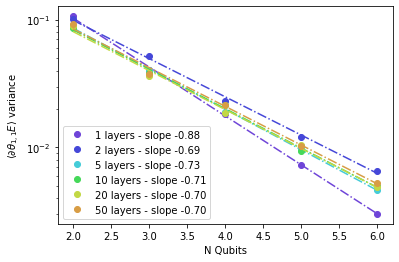

In [ ]:
# plot_gradients(layers, qubits, global_circuit)

Local cost function
==========================================

Repeating a similar analysis with a local cost function (measuring only 2 qubits)

In [ ]:
def local_circuit(params):
    """A random variational quantum circuit.

    Args:
        params (array[array[float]]): array of parameters of dimension (num_layers, num_qubits) containing the rotation angles

    Returns:
        float: the expectation value of the target observable
    """
    # Relevant parameters
    assert(len(np.shape(params)) == 2)      # check proper dimensions of params
    num_layers = np.shape(params)[0]        # np.shape(params) = (num_layers, num_qubits)
    num_qubits = np.shape(params)[1]
    
    # Generating the gate sequence from randomly applying RX, RY or RZ with the corresponding rotation angle
    gate_set = [qml.RX, qml.RY, qml.RZ]
    random_gate_sequence = [[np.random.choice(gate_set) for _ in range(num_qubits)] for _ in range(num_layers)]

    # Initial rotations on all qubits
    for i in range(num_qubits):             # rotate all qubits
        qml.RY(np.pi / 4, wires=i)          # "to prevent X, Y , or Z from being an especially preferential 
                                            # direction with respect to gradients."

    # Repeating a layer structure
    for l in range(num_layers):
        # Single random gate layer (single qubit rotations)
        for i in range(num_qubits):
            random_gate_sequence[l][i](params[l][i], wires=i)
        # Nearest neighbour controlled phase gates
        if num_qubits > 1:                          # no entangling gates if using a single qubit
            for i in range(num_qubits - 1):
                qml.CZ(wires=[i, i + 1])
            if num_qubits > 2:                      # avoid 2 CZ gates on the same wires
                qml.CZ(wires=[num_qubits-1, 0])

    # Objective operator H = Z_1 Z_2
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [ ]:
generate_gradients(layers, qubits, local_circuit)

1  layers
2  layers
5  layers
10  layers
20  layers
50  layers


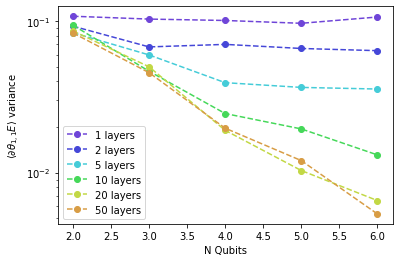

In [ ]:
# plot_gradients(layers, qubits, local_circuit)

References
==========

1.  McClean, Jarrod R., et al., Barren plateaus in quantum neural
    network training landscapes. Nature communications 9.1 (2018): 4812.
2.  Holmes, Zoë, et al., Connecting ansatz expressibility to gradient 
    magnitudes and barren plateaus. arXiv:2101.02138
3.  Shahawaz, Ahmed, Barren plateaus in quantum neural networks 
    (https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html)
4.  PennyLane dev team, Variational Calssifier 
    (https://pennylane.ai/qml/demos/tutorial_variational_classifier.html#fitting-the-parity-function)

